# Проект для «Викишоп» c BERT

Дата: 25 июля 2023  
Исполнитель: Троицкий Илья  
Проект выполнен в рамках курса Datascience Bootcamp  

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Общее-впечатление" data-toc-modified-id="Общее-впечатление-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span><font color="orange">Общее впечатление</font></a></span></li><li><span><a href="#Общее-впечатление-(ревью-2)" data-toc-modified-id="Общее-впечатление-(ревью-2)-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span><font color="orange">Общее впечатление (ревью 2)</font></a></span></li><li><span><a href="#Общее-впечатление-(ревью-3)" data-toc-modified-id="Общее-впечатление-(ревью-3)-0.3"><span class="toc-item-num">0.3&nbsp;&nbsp;</span><font color="orange">Общее впечатление (ревью 3)</font></a></span></li></ul></li><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Проверка-на-тестовых-данных" data-toc-modified-id="Проверка-на-тестовых-данных-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Проверка на тестовых данных</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

## Описание проекта

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import transformers
import matplotlib.pyplot as plt

from tqdm import notebook

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier, Pool

In [2]:
#BERT_MODEL = 'prajjwal1/bert-tiny' # Каталог с пре-тренированной моделью BERT
#BERT_MODEL = 'unitary/toxic-bert' # указать distilbert есть будем работать с моделью из библиотеки transformers
BERT_MODEL = 'distilbert'

SAMPLE_SIZE = 1000 # количество элементов в выборке 
BATCH_SIZE = 50 # Размер батча для формирования эмбедингов

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
if (BERT_MODEL == 'distilbert'):
    model_class, tokenizer_class, pretrained_weights = (transformers.DistilBertModel,
                                                        transformers.DistilBertTokenizer,
                                                        'distilbert-base-uncased')

    tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
    model = model_class.from_pretrained(pretrained_weights)
    print('Загружена модель Distilbert')
elif (BERT_MODEL == 'prajjwal1/bert-tiny'):
    model = transformers.BertModel.from_pretrained(BERT_MODEL)
    tokenizer = transformers.BertTokenizer.from_pretrained(BERT_MODEL)
    print(f'Загружена модель {BERT_MODEL}.')  
elif (BERT_MODEL == 'unitary/toxic-bert'):
    model = transformers.BertModel.from_pretrained(BERT_MODEL)
    tokenizer = transformers.BertTokenizer.from_pretrained(BERT_MODEL)
    print(f'Загружена модель {BERT_MODEL}.')       
else:    
    model = transformers.BertModel.from_pretrained(BERT_MODEL)
    tokenizer = transformers.BertTokenizerFast(vocab_file='{}/vocab.txt'.format(BERT_MODEL))
    print(f'Загружена модель {BERT_MODEL}.')


Загружена модель Distilbert


In [5]:
if (os.path.exists('/datasets')):
    df = pd.read_csv('/datasets/toxic_comments.csv')
elif (os.path.exists('datasets')):
    df = pd.read_csv('datasets/toxic_comments.csv')
elif os.path.exists('toxic_comments.csv'):
    df = pd.read_csv('toxic_comments.csv')
else:    
    raise Exception('Не найден файл с данными.')    

print('Данные успешно загружены.')

Данные успешно загружены.


In [6]:
print(df.shape)
df.info()
display(df.head())

(159292, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [7]:
df = df.drop('Unnamed: 0', axis=1)
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


Посмотрит какой длины текст бывает

In [8]:
text_len = df.text.map(len)
text_len.describe()


count    159292.000000
mean        393.691303
std         590.111825
min           5.000000
25%          95.000000
50%         205.000000
75%         435.000000
max        5000.000000
Name: text, dtype: float64

<Axes: >

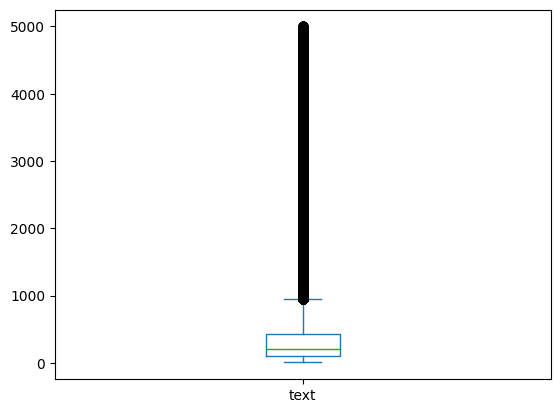

In [9]:
text_len.plot.box()

Я не придумал, как выбросить тексты, которые после токенизации имеют больше допустимого количества токенов, поэтому отсек все тексты длинне 512 символов.

In [10]:
TOKENS_LIMIT = 512
df = df[text_len < TOKENS_LIMIT]
df.shape

(126276, 2)

In [11]:
toxic_share = df['toxic'].value_counts(normalize=True)[1]
print(toxic_share)

0.1121036459818176


В данных находится 159292 коммента. Удалили столбец с номером строки. Очистили данные от аномально больших текстов, теперь самый длинный текст короче 1001 символа.

In [12]:
#data = df.sample(SAMPLE_SIZE).reset_index(drop=True)
#data['toxic'].value_counts(normalize=True)

Рассчитаем количество элементов, для включения в выборку , чтобы при последующем разделении, у нас оказалось попалам классов в трейин выборке, и оригинальное соотнощие классов в тестовой

In [13]:
toxic_data = df[df['toxic'] == 1]
nice_data = df[df['toxic'] == 0]
nice_data_qty = round((toxic_data.shape[0] * 0.8) + (toxic_data.shape[0] * 0.2 )/ toxic_share)

print(toxic_data.shape[0])
print(nice_data_qty)

14156
36580


In [14]:
#data = pd.concat([toxic_data, nice_data.sample(nice_data_qty)]).reset_index(drop=True)
#data = data.sample(round(data.shape[0] / 2)).reset_index(drop=True)
#print(data.shape)

In [15]:

data = pd.concat([nice_data.sample(9500), toxic_data.sample(5500)]).reset_index(drop=True)
print(data.shape)

(15000, 2)


Выполним токенизацию

Представление ошибки, если по какому то тексту, будет сформировано большое количество токенов. 

Token indices sequence length is longer than the specified maximum sequence length for this model (623 > 512). Running this sequence through the model will result in indexing errors

In [16]:
%%time

tokenized = data['text'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True))

CPU times: user 5.24 s, sys: 4.21 ms, total: 5.25 s
Wall time: 5.27 s


Посмотрим что получилось на первом элементе

In [17]:
print('text:', data['text'][0])
print('len:', len(data['text'][0]))
print('tokens:', tokenized[0])
print('len: ', len(tokenized[0]))

text: measures and actions. You are already in the hot list in Miss Earth. Thanks.
len: 76
tokens: [101, 5761, 1998, 4506, 1012, 2017, 2024, 2525, 1999, 1996, 2980, 2862, 1999, 3335, 3011, 1012, 4283, 1012, 102]
len:  19


Теперь найдем максимальную длину списка токенов, заодно посмотри что за текст имеет столько токенов


In [18]:
max_len = 0
y = 0
max_len_index = 0

for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)
        max_i = y
    y += 1    

print(data['text'][max_i])
print(max_len)   

TIDEROLL LIKES TO GAG ON COCK 

tideroll is dick suckin asshole who never had straight thoughts in heshe's life.FUCK YOU BITCH!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
380


В тексте, с самым большим вектором токеном содержится огромное количество занков препинания.

Теперь сделаем все векторы одинакого размера и составим маску внимания

In [19]:
padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)

Создадим эмбеденнги

In [20]:
%%time 

embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // BATCH_SIZE)):
        batch = torch.LongTensor(padded[BATCH_SIZE*i:BATCH_SIZE*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[BATCH_SIZE*i:BATCH_SIZE*(i+1)])
        
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].numpy())

  0%|          | 0/300 [00:00<?, ?it/s]

CPU times: user 2h 26min 28s, sys: 35min 39s, total: 3h 2min 7s
Wall time: 32min 9s


## Обучение

Создадим фичи и целевой признак

In [23]:
features = np.concatenate(embeddings)
target = data['toxic']
print(target.shape)

(15000,)


In [24]:
target

0        0
1        0
2        0
3        0
4        0
        ..
14995    1
14996    1
14997    1
14998    1
14999    1
Name: toxic, Length: 15000, dtype: int64

In [26]:

toxic_train, toxic_test = train_test_split(target[target == 1], test_size=0.11)
nice_train, nice_test = train_test_split(target[target == 0], test_size=0.47)

print(toxic_train.shape)
print(toxic_test.shape)
print(nice_train.shape)
print(nice_test.shape)


y_train = pd.concat([toxic_train, nice_train])
y_test = pd.concat([toxic_test, nice_test])

X_train = features[y_train.index]
X_test = features[y_test.index]

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

print(y_test.value_counts(normalize=True))

(4895,)
(605,)
(5035,)
(4465,)
(9930, 768)
(5070, 768)
(9930,)
(5070,)
toxic
0    0.880671
1    0.119329
Name: proportion, dtype: float64


Обучим логистическую регрессию

In [28]:
%%time 

param_grid = {'C': [0.1, 0.5, 1, 5, 10] }


est = LogisticRegression(max_iter = 10000, random_state = 31337)
clf = GridSearchCV(est, 
                   cv=5, 
                   scoring='f1', 
                   param_grid=param_grid,
                   n_jobs=5)

clf.fit(X_train, y_train)

LR_model = clf.best_estimator_
print('Logistic Regression F1: ', f1_score(y_train, LR_model.predict(X_train)))

Logistic Regression F1:  0.917069160415168
CPU times: user 28.3 s, sys: 10 s, total: 38.3 s
Wall time: 1min 4s


Обучим CatBoost

In [29]:
%%time 

cat = CatBoostClassifier(random_seed=31337,
                          iterations=500,
                          custom_metric='F1',
                          logging_level='Silent',
                          )

param_grid = {
    'num_leaves': [31, 127],
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.1, 0.01]
}

grid_search_result = cat.grid_search(param_grid,
            X=X_train,
            y=y_train,
            cv=3,
            partition_random_seed=31337,
            calc_cv_statistics=True,
            search_by_train_test_split=True,
            refit=True,
            shuffle=True,
            stratified=None,
            train_size=0.8,
            verbose=True,
            plot=False,
            )
            
print('CatBoost F1 score:', cat.best_score_)

0:	loss: 0.2937032	best: 0.2937032 (0)	total: 2.54s	remaining: 27.9s
1:	loss: 0.4852627	best: 0.2937032 (0)	total: 4.89s	remaining: 24.5s
2:	loss: 0.2754338	best: 0.2754338 (2)	total: 9.8s	remaining: 29.4s
3:	loss: 0.4021003	best: 0.2754338 (2)	total: 14.6s	remaining: 29.3s
4:	loss: 0.2667482	best: 0.2667482 (4)	total: 21.5s	remaining: 30.1s
5:	loss: 0.3607970	best: 0.2667482 (4)	total: 28.4s	remaining: 28.4s
Estimating final quality...
CatBoost F1 score: {'learn': {'F1': 0.9523323466367256, 'Logloss': 0.15747862632035342}}
CPU times: user 9min 26s, sys: 11.5 s, total: 9min 38s
Wall time: 55.9 s


In [30]:
print(grid_search_result['params'])


CB_model = CatBoostClassifier(**grid_search_result['params'], 
                              random_seed=31337, 
                              logging_level='Silent')
CB_model.fit(X_train,y_train)

{'max_leaves': 31, 'iterations': 150, 'learning_rate': 0.1}


Ради интереса, возьмем модет CatBoost с вручную заданными метапараметрами

In [31]:
%%time 

cb_manual = CatBoostClassifier(eval_metric='F1',
                        random_seed=31337,
                        logging_level='Silent',
                        iterations=500,
                        od_type='Iter',
                        od_wait=500)
cb_manual.fit(X_train,y_train)
print(cb_manual.get_best_score())

{'learn': {'Logloss': 0.0929405005901289, 'F1': 0.9896949290888686}}
CPU times: user 3min 56s, sys: 3.22 s, total: 4min
Wall time: 22.3 s


На данных обучения, лучшую оценку показываеть модель CatBoost, полученная с помощью перебора метапараметров

In [32]:
best_model = CB_model

### Проверка на тестовых данных

In [33]:
print('best_model F1 score:', f1_score(y_test, best_model.predict(X_test)))

best_model F1 score: 0.6752450980392157


Сравним с Dummy classifier

In [34]:
from sklearn.dummy import DummyClassifier
clf = DummyClassifier()

scores = cross_val_score(clf, X_test, y_test, scoring='f1')
print(scores)

[0. 0. 0. 0. 0.]


## Выводы

В датасете представлены тексты комментариев и содержиться целевой признак  `toxic`. Данные очищены от лишней информации. Произведено превращение текста в токены и последуюшая ембедизация с помощью пред-обученной модели BERT-tiny. На получившихся признаках обучены модели логистической регрессии и CatBoost. В процессе обуения CatBoost показала лучший результат, поэтому она выбирается как финальная. На тестовых данных результаты выше, чем у искуственной модели. Использую предобученную модель bert-toxic удалось достичь оценки F1 0.93, что выше требуемой по ТЗ.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Модели обучены
- [ ]  Значение метрики *F1* не меньше 0.75
- [ ]  Выводы написаны